In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

def show(df):
    for j in df.index:
        print(j)
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
        X = grid_of_images_default(X)
        imsave('out.png', X)
        im = Image('out.png')
        display(im)
db = load_db()

In [2]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
        
    for k, v in j['stats'].items():
        col[k] = v

    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    col['digits_object'] = 1 - col['digits_entropy']
    col['letters_object'] = 1 - col['letters_entropy']
    col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')

## Fix stride. vary nb of layers

In [82]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9e80faae4fb4ae36b2766648824eac09,128.0,0.116791,0.883209,12.550046,0.086,0.800376,0.191304,6.500855e+07,0.078,0.002076,0.808696,4.151053,0.018,0.013,0.757,0.352276,0.141,0.647724,5.123708,0.522073,0.082004,14.290085,0.848,0.810578,0.347885,1.427359e+08,0.501,0.002082,0.652115,5.316375,1,6529.0,NaN,0.066,mnist_deep,2.0,NaN
68adffea6c98fedf329644122d56fa36,128.0,0.039539,0.960461,19.538910,0.577,0.911845,0.087772,6.482822e+07,0.517,0.002000,0.912228,6.700230,0.090,0.080,0.568,0.248701,0.173,0.751299,13.314023,0.788424,0.112240,57.670715,0.365,0.926126,0.116562,1.426116e+08,0.316,0.002006,0.883438,14.033784,2,825985.0,NaN,0.058,mnist_deep,2.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.031575,0.968425,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002000,0.915515,6.845440,0.108,0.096,0.482,0.246643,0.154,0.753357,12.352144,0.765771,0.100727,52.514980,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,0.889532,14.415942,3,1645441.0,NaN,0.043,mnist_deep,2.0,NaN
63c1be88f742117d115d076216ac85d1,128.0,0.020904,0.979096,10.919588,0.849,0.916866,0.055326,6.480193e+07,0.794,0.002000,0.944674,7.269512,0.130,0.121,0.440,0.208254,0.196,0.791746,10.687059,0.676443,0.095547,33.215351,0.124,0.778797,0.088160,1.426905e+08,0.113,0.002006,0.911840,9.548794,4,2464897.0,NaN,0.027,mnist_deep,2.0,NaN
581582abec259852f4a01f7e79ed97db,128.0,0.020118,0.979882,7.382170,0.964,0.851105,0.056269,6.483472e+07,0.886,0.002008,0.943731,6.220617,0.128,0.122,0.458,0.212822,0.178,0.787178,8.264774,0.614825,0.109743,22.542377,0.024,0.767487,0.096898,1.427642e+08,0.021,0.002014,0.903102,9.044111,5,3284353.0,NaN,0.012,mnist_deep,2.0,NaN
8ecaf99d22cf4cb469912b9fae25aac2,128.0,0.008583,0.991417,4.169066,0.998,0.630844,0.042352,6.493132e+07,0.967,0.005644,0.957648,3.949130,0.098,0.093,0.331,0.196629,0.108,0.803371,5.691341,0.426911,0.099368,8.652865,0.001,0.602850,0.086963,1.428706e+08,0.001,0.005650,0.913037,5.471218,6,4103809.0,NaN,0.001,mnist_deep,2.0,NaN


9e80faae4fb4ae36b2766648824eac09


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


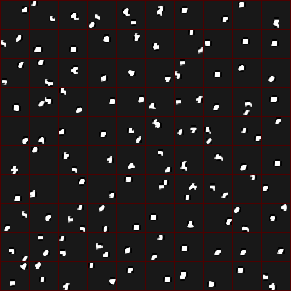

68adffea6c98fedf329644122d56fa36


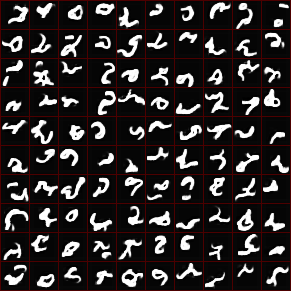

901dad8ec11f23191d86fa6279d47c65


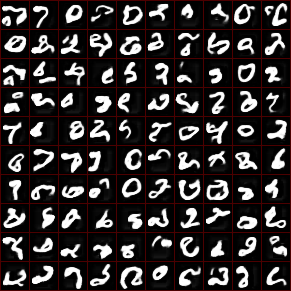

63c1be88f742117d115d076216ac85d1


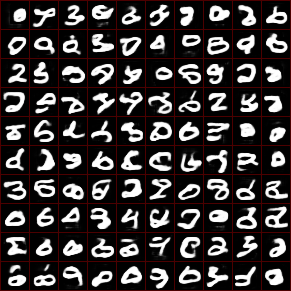

581582abec259852f4a01f7e79ed97db


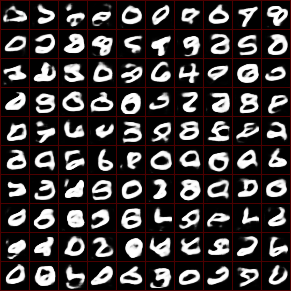

8ecaf99d22cf4cb469912b9fae25aac2


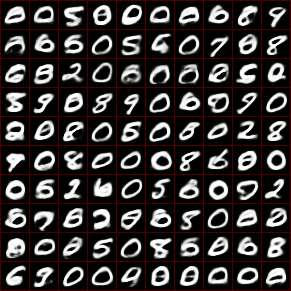

In [83]:
show(df)

## Fix nb layers. Vary stride

In [77]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5511413bb44248b61f32518f638a8d9e,128.0,0.043103,0.956897,15.068205,0.712,0.912121,0.109552,6.482374e+07,0.621,0.002,0.890448,6.414445,0.031,0.029,0.694,0.310742,0.131,0.689258,8.729666,0.646863,0.100108,26.331829,0.231,0.917145,0.121261,1.426300e+08,0.193,0.002006,0.878739,13.536750,3,1645441.0,NaN,0.057,mnist_deep,0.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,0.031410,0.968590,14.714568,0.773,0.924139,0.083757,6.478472e+07,0.713,0.002,0.916243,6.948976,0.081,0.073,0.572,0.254680,0.178,0.745320,12.290185,0.775435,0.104893,55.180447,0.172,0.926554,0.101766,1.426092e+08,0.153,0.002006,0.898234,14.877086,3,1645441.0,NaN,0.055,mnist_deep,1.0,NaN
901dad8ec11f23191d86fa6279d47c65,128.0,0.031575,0.968425,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002,0.915515,6.845440,0.108,0.096,0.482,0.246643,0.154,0.753357,12.352144,0.765771,0.100727,52.514980,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,0.889532,14.415942,3,1645441.0,NaN,0.043,mnist_deep,2.0,NaN
60168f92bfbc6331027b213e2e9d4f6f,128.0,0.034976,0.965024,13.157985,0.771,0.937145,0.083086,6.482572e+07,0.694,0.002,0.916914,7.141914,0.122,0.109,0.453,0.245890,0.142,0.754110,10.135502,0.757821,0.114442,47.322350,0.179,0.877613,0.115620,1.426912e+08,0.157,0.002006,0.884380,12.196813,3,1645441.0,NaN,0.050,mnist_deep,4.0,NaN


5511413bb44248b61f32518f638a8d9e


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


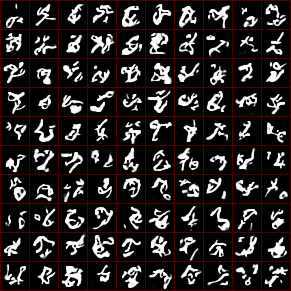

f316dedd30ebc5f51c4678f07979436c


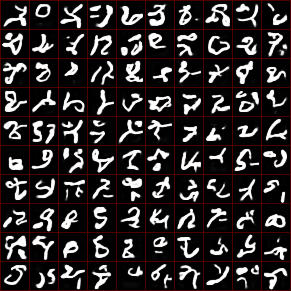

901dad8ec11f23191d86fa6279d47c65


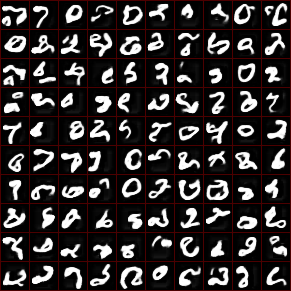

60168f92bfbc6331027b213e2e9d4f6f


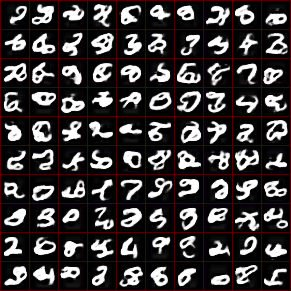

In [66]:
show(df)

# wta lifetime sparsity

In [67]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5df44b4a1f76008eafba6e9b566478c6,128.0,0.522662,0.477338,3.300958,0.042,4.883483e-01,0.377219,6.508613e+07,0.038,0.328624,0.622781,2.131843,0.011,0.010,0.336,0.628205,0.066,0.371795,2.446524,3.160054e-01,0.588261,4.250678,0.938,5.265812e-01,0.683533,1.428550e+08,0.233,0.328630,0.316467,2.126026,1,6529.0,NaN,0.020,mnist_deep_lifetime,NaN,0.7
23d22605e16298e02bf390236e483914,128.0,0.233133,0.766867,11.505471,0.285,7.997974e-01,0.239657,6.488142e+07,0.250,0.090506,0.760343,4.112755,0.058,0.051,0.406,0.279916,0.110,0.720084,8.497730,6.513849e-01,0.183228,26.278839,0.676,7.665223e-01,0.320328,1.426311e+08,0.332,0.090512,0.679672,7.157652,2,825985.0,NaN,0.039,mnist_deep_lifetime,NaN,0.7
22f21be8ae12aba3457e2469d290dd52,128.0,0.639410,0.360590,0.999999,0.000,-4.342945e-11,0.397720,NaN,0.000,1.001000,0.602280,0.999993,0.000,0.000,0.000,0.883035,0.000,0.116965,1.000001,-1.712995e-11,0.859961,0.999999,0.000,-3.069277e-11,0.805414,NaN,0.000,1.001006,0.194586,1.000004,3,1645441.0,NaN,1.000,mnist_deep_lifetime,NaN,0.7
cf34fddfc38e4eed28e73fcffa2f7066,128.0,0.034312,0.965688,13.207333,0.846,9.613887e-01,0.074755,6.479994e+07,0.769,0.002006,0.925245,7.707634,0.102,0.084,0.456,0.275638,0.130,0.724362,12.693130,7.584960e-01,0.132599,42.675426,0.098,9.324401e-01,0.102940,1.426632e+08,0.087,0.002012,0.897060,14.936293,4,2464897.0,NaN,0.056,mnist_deep_lifetime,NaN,0.7
5c5bf9994c2b1ba4d86540bb8f9c3091,128.0,0.024189,0.975811,11.187900,0.909,9.681023e-01,0.073043,6.480941e+07,0.844,0.002000,0.926957,7.829299,0.119,0.105,0.469,0.271232,0.140,0.728768,11.279076,7.360543e-01,0.124638,39.702442,0.067,8.687896e-01,0.105799,1.426949e+08,0.060,0.002006,0.894201,12.161733,5,3284353.0,NaN,0.024,mnist_deep_lifetime,NaN,0.7
f7a80edd7d1c9c90515651e3e86798d4,128.0,0.023830,0.976170,10.132069,0.928,9.539540e-01,0.063367,6.480640e+07,0.852,0.002000,0.936633,7.822666,0.141,0.130,0.415,0.264687,0.134,0.735313,11.650751,7.187109e-01,0.137298,34.465794,0.038,8.751838e-01,0.103406,1.427050e+08,0.035,0.002006,0.896594,12.472565,6,4103809.0,NaN,0.034,mnist_deep_lifetime,NaN,0.7


5df44b4a1f76008eafba6e9b566478c6


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


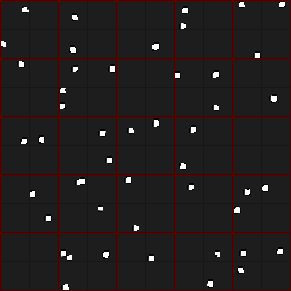

23d22605e16298e02bf390236e483914


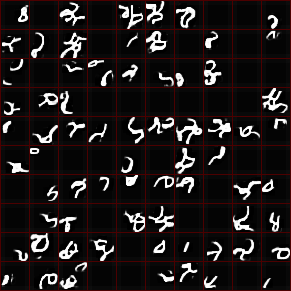

22f21be8ae12aba3457e2469d290dd52


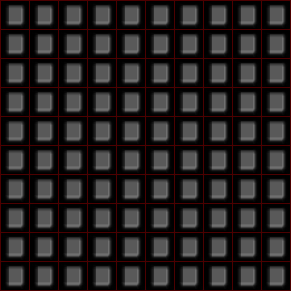

cf34fddfc38e4eed28e73fcffa2f7066


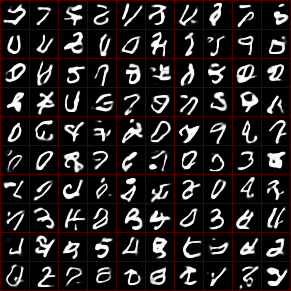

5c5bf9994c2b1ba4d86540bb8f9c3091


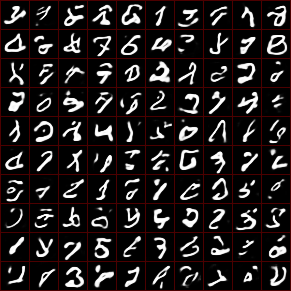

f7a80edd7d1c9c90515651e3e86798d4


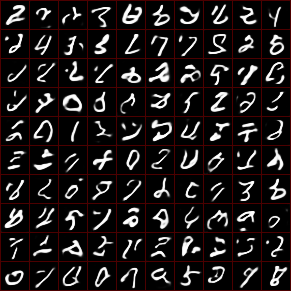

In [68]:
show(df)

## wta kchannel

In [69]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86edda1cd4ca18d86af1d30a3691743c,128.0,0.080477,0.919523,17.730999,0.155,0.831264,0.163009,6.493536e+07,0.133,0.002000,0.836991,4.641634,0.031,0.030,0.761,0.286676,0.197,0.713324,6.872862,0.595692,0.084899,21.616522,0.751,0.874809,0.216747,1.426393e+08,0.559,0.002006,0.783253,8.915785,1,6529.0,NaN,0.094,mnist_deep_kchannel,NaN,0.9
e2a3cf325e945c1a0be38073933f5938,128.0,0.051193,0.948807,20.280416,0.509,0.922437,0.105584,6.486263e+07,0.438,0.002000,0.894416,6.592316,0.082,0.074,0.580,0.259248,0.167,0.740752,11.651826,0.780166,0.112815,52.920902,0.426,0.935885,0.134873,1.426424e+08,0.347,0.002006,0.865127,13.841786,2,825985.0,NaN,0.065,mnist_deep_kchannel,NaN,0.9
876bbdc0501b9e043d5e566bc13f6a5a,128.0,0.036674,0.963326,14.189510,0.693,0.921693,0.077887,6.480994e+07,0.636,0.002000,0.922113,7.004585,0.125,0.113,0.425,0.238127,0.164,0.761873,11.007601,0.729812,0.097576,43.878284,0.251,0.890408,0.114385,1.426517e+08,0.211,0.002006,0.885615,12.584548,3,1645441.0,NaN,0.056,mnist_deep_kchannel,NaN,0.9
e72e79bf4cd53875e7ec8784a64b45ce,128.0,0.035782,0.964218,13.253835,0.797,0.962560,0.097950,6.485025e+07,0.715,0.002012,0.902050,7.298103,0.097,0.091,0.501,0.271282,0.128,0.728718,11.336662,0.736383,0.112633,42.219612,0.157,0.860804,0.093629,1.427092e+08,0.136,0.002018,0.906371,12.298592,4,2464897.0,NaN,0.046,mnist_deep_kchannel,NaN,0.9
40b4aa2f3f994823faf01e804567b430,128.0,0.027230,0.972770,10.462719,0.878,0.912284,0.068199,6.482983e+07,0.803,0.002004,0.931801,7.043870,0.136,0.126,0.414,0.242237,0.135,0.757763,10.329323,0.701115,0.124744,32.360668,0.090,0.817857,0.097824,1.427340e+08,0.079,0.002010,0.902176,10.536287,5,3284353.0,NaN,0.032,mnist_deep_kchannel,NaN,0.9
bb8051dece1c1d1c64b96ec2a6e53179,128.0,0.015016,0.984984,6.574772,0.945,0.741461,0.036610,6.492172e+07,0.904,0.007648,0.963390,5.054827,0.214,0.209,0.544,0.152843,0.311,0.847157,9.197904,0.635446,0.132672,23.531170,0.033,0.675831,0.073278,1.428226e+08,0.033,0.007654,0.926722,7.549600,6,4103809.0,NaN,0.022,mnist_deep_kchannel,NaN,0.9


86edda1cd4ca18d86af1d30a3691743c


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


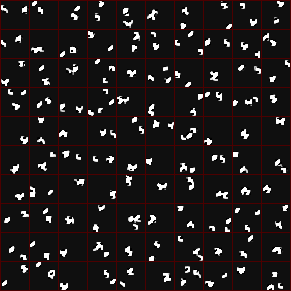

e2a3cf325e945c1a0be38073933f5938


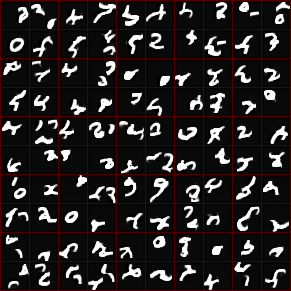

876bbdc0501b9e043d5e566bc13f6a5a


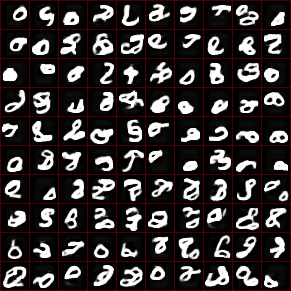

e72e79bf4cd53875e7ec8784a64b45ce


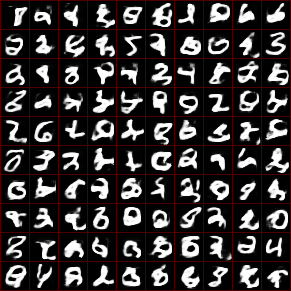

40b4aa2f3f994823faf01e804567b430


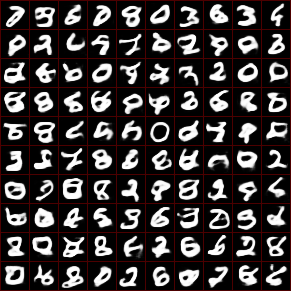

bb8051dece1c1d1c64b96ec2a6e53179


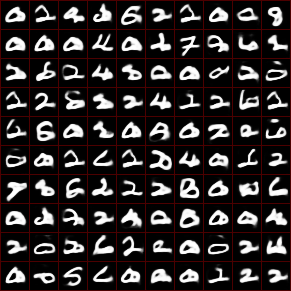

In [70]:
show(df)

In [71]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
414122cb7ccc4a125385d75e5c0eb585,128.0,0.034061,0.965939,12.497256,0.804,0.923587,0.097247,6.480683e+07,0.723,0.002000,0.902753,6.797603,0.076,0.065,0.571,0.273740,0.163,0.726260,10.970304,0.770649,0.105082,53.092396,0.153,0.854546,0.096067,1.426501e+08,0.128,0.002006,0.903933,11.954018,4,2464897.0,NaN,0.043,mnist_deep_kchannel,NaN,0.7
e72e79bf4cd53875e7ec8784a64b45ce,128.0,0.035782,0.964218,13.253835,0.797,0.962560,0.097950,6.485025e+07,0.715,0.002012,0.902050,7.298103,0.097,0.091,0.501,0.271282,0.128,0.728718,11.336662,0.736383,0.112633,42.219612,0.157,0.860804,0.093629,1.427092e+08,0.136,0.002018,0.906371,12.298592,4,2464897.0,NaN,0.046,mnist_deep_kchannel,NaN,0.9


414122cb7ccc4a125385d75e5c0eb585


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


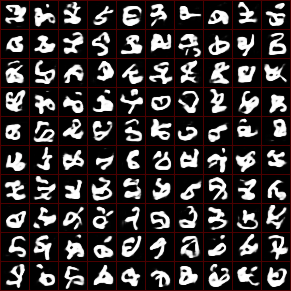

e72e79bf4cd53875e7ec8784a64b45ce


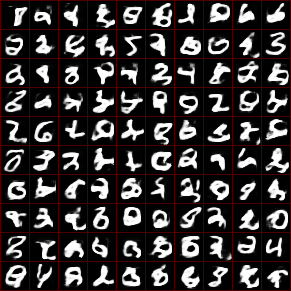

In [72]:
show(df)

7e7632c0f86786bda97931c4e88bbfd7


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


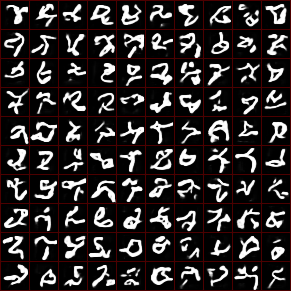

b75919e611b9c6ed0f063749d17ad699


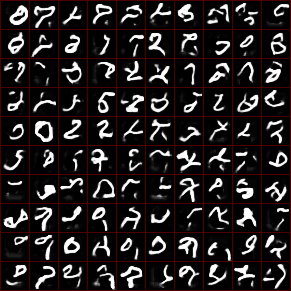

ab45d34bd45790c492f913e11f28b1dd


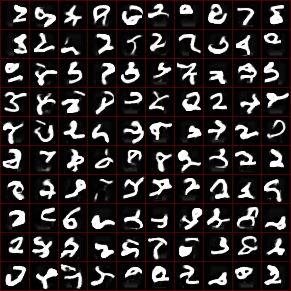

0debb69cc1446f1d7a5a96f811862415


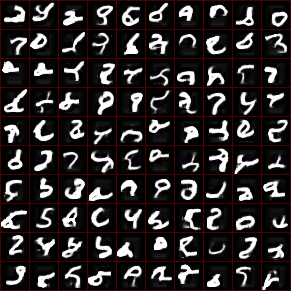

9e5973159e0e38f7e10955524bc5607e


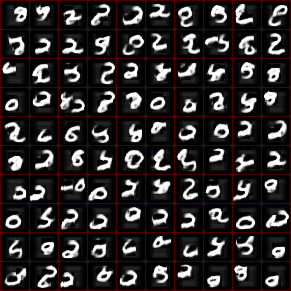

2c9eb506fa05e9a7443d23accf19db0b


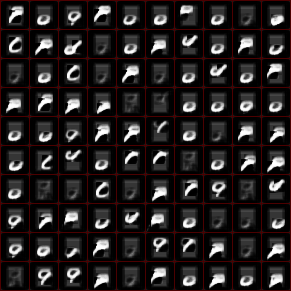

In [75]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

6ceac389d453ad7150255ccefded856d


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


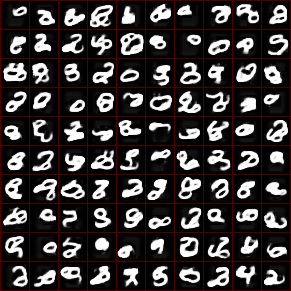

12b0486a0d443763cff37a8e15717a0d


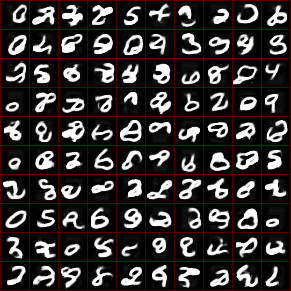

a26b661b10ec3f4a68d9bd6454c5e70b


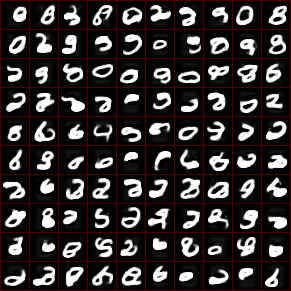

4b472da80b52e26b09a8e707ba4eaf6b


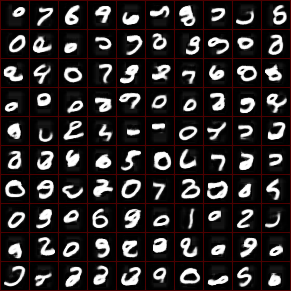

c66d4d7f3ef76fd52b2c6b354e94c3d0


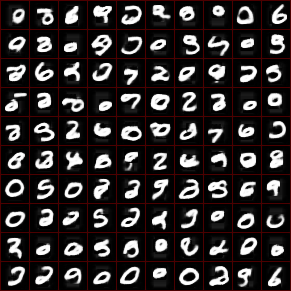

In [76]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

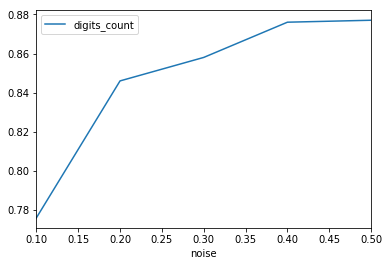

In [52]:
df.plot('noise', ['digits_count'])

6ceac389d453ad7150255ccefded856d


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


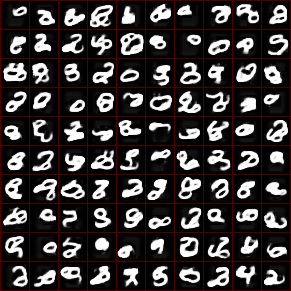

12b0486a0d443763cff37a8e15717a0d


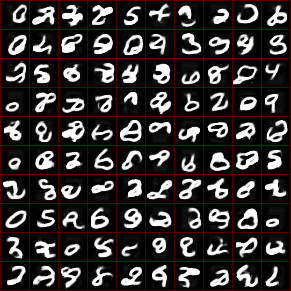

a26b661b10ec3f4a68d9bd6454c5e70b


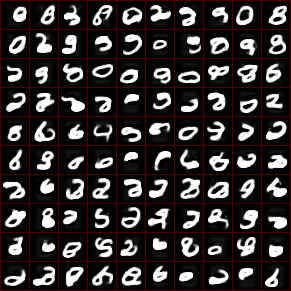

4b472da80b52e26b09a8e707ba4eaf6b


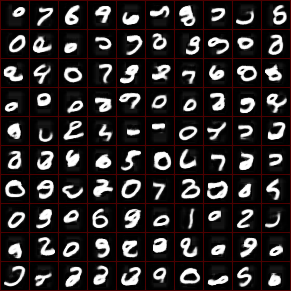

c66d4d7f3ef76fd52b2c6b354e94c3d0


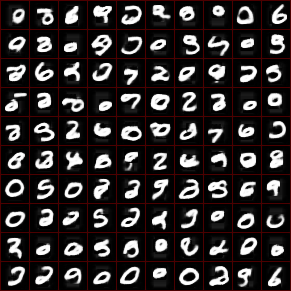

In [56]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)